In [2]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import cnn_encoder



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/

In [3]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(feature_selection_threshold = 2, 
                                                                        retain_phases="Both", 
                                                                        return_id= True,
                                                                        normalization = False,
                                                                        as_time_series = True)


Retaining patients that are included in phases 1 & 2
retaining all patient who have passed all visits...
loading samples...
loaded 1455 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
selecting genes based on median absolute deviation threshold:  2 ...
number of genes selected :  12140
number of seq in the dataset : 1455
converting samples to time series
number of actual individual to be studied : 291


In [39]:
importlib.reload(cnn_encoder) # to allow modification of the script without restarting the whole session

latent_dim = 32
sequence_length = 5
t_shape = (sequence_length, n_genes)


autoencoder = cnn_encoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [40]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=25, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=50)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, 
      reduce_lr, 
      early_stopping_callback, 
      tensorboard_callback]

In [41]:
#autoencoder.build(input_shape = (None, sequence_length, n_genes))
#autoencoder.encoder.summary()
#autoencoder.decoder.summary()

In [55]:
hist = autoencoder.fit(x_train, epochs=2000, callbacks=cb)

Epoch 1/2000
5/5 [==============================] - 2s 333ms/step - loss: 0.1300 - lr: 1.0000e-05
Epoch 2/2000
5/5 [==============================] - 1s 299ms/step - loss: 0.1300 - lr: 1.0000e-05
Epoch 3/2000
5/5 [==============================] - 1s 275ms/step - loss: 0.1300 - lr: 1.0000e-05
Epoch 4/2000
5/5 [==============================] - 1s 297ms/step - loss: 0.1300 - lr: 1.0000e-05
Epoch 5/2000
5/5 [==============================] - 1s 289ms/step - loss: 0.1300 - lr: 1.0000e-05
Epoch 6/2000
5/5 [==============================] - 1s 291ms/step - loss: 0.1300 - lr: 1.0000e-05
Epoch 7/2000
5/5 [==============================] - 1s 280ms/step - loss: 0.1300 - lr: 1.0000e-05
Epoch 8/2000
5/5 [==============================] - 1s 279ms/step - loss: 0.1300 - lr: 1.0000e-05
Epoch 9/2000
5/5 [==============================] - 1s 300ms/step - loss: 0.1300 - lr: 1.0000e-05
Epoch 10/2000
5/5 [==============================] - 1s 296ms/step - loss: 0.1300 - lr: 1.0000e-05
Epoch 11/2000
5/5 [

5/5 [==============================] - 22s 5s/step - loss: 2.2247e-06 - lr: 1.0000e-05


In [56]:
autoencoder.load_weights(checkpoint_filepath)



[0.13107849657535553, 0.13107658922672272, 0.13107462227344513, 0.1310725212097168, 0.13107046484947205, 0.13106854259967804, 0.13106653094291687, 0.13106462359428406, 0.1310628056526184, 0.13106085360050201, 0.13105888664722443, 0.13105683028697968, 0.13105478882789612, 0.13105270266532898, 0.131050705909729, 0.131048783659935, 0.13104678690433502, 0.1310449093580246, 0.13104306161403656, 0.13104112446308136, 0.13103917241096497, 0.1310371458530426, 0.13103502988815308, 0.13103294372558594, 0.13103094696998596, 0.13102898001670837, 0.13102704286575317, 0.13102513551712036, 0.13102319836616516, 0.13102130591869354, 0.13101930916309357, 0.13101723790168762, 0.13101525604724884, 0.13101321458816528, 0.1310112327337265, 0.13100925087928772, 0.13100731372833252, 0.1310053914785385, 0.13100343942642212, 0.1310015171766281, 0.13099952042102814, 0.13099750876426697, 0.13099552690982819, 0.13099348545074463, 0.13099145889282227, 0.13098950684070587, 0.1309874802827835, 0.13098549842834473, 0.1

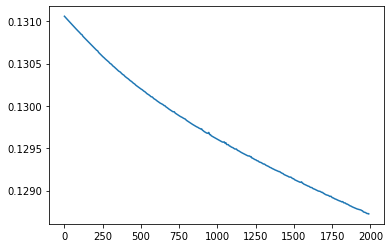

In [57]:
plt.plot(hist.history['loss'][10:])
print(hist.history['loss'])




In [58]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
decoded = autoencoder.decoder(z)

In [59]:
e_ = e[0]  
z_ = z[0].reshape(1, -1) 
decoded_ = decoded[0]  



# Create subplot grid with vertical stacking
fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=False, vertical_spacing=0.1)

# Add the original image as a heatmap-like plot
heatmap_trace1 = go.Heatmap(z=e_, colorscale='viridis')
fig.add_trace(heatmap_trace1, row=1, col=1)

# Add the latent representation as a heatmap-like plot
tensor_reshaped = z.reshape(1, -1)
heatmap_trace2 = go.Heatmap(z=z_, colorscale='viridis')
fig.add_trace(heatmap_trace2, row=2, col=1)

# Add the decoded image as a heatmap-like plot
heatmap_trace3 = go.Heatmap(z=decoded_, colorscale='viridis')
fig.add_trace(heatmap_trace3, row=3, col=1)

# Update layout
fig.update_layout(title='Stacked Graph of Image and Latent Space', showlegend=False)

# Update x-axis labels
#fig.update_xaxes(title_text='genes (normalized)', row=1, col=1)
#fig.update_xaxes(title_text='latent representation', row=2, col=1)
#fig.update_xaxes(title_text='genes (normalized)', row=3, col=1)

# Update y-axis labels
#fig.update_yaxes(title_text='timestamps', row=1, col=1)
#fig.update_yaxes(title_text='latent representation', row=2, col=1)
#fig.update_yaxes(title_text='timestamps', row=3, col=1)

fig.show()

In [60]:
autoencoder.encoder.save('../workfiles/cnn_autoencoer_model')


INFO:tensorflow:Assets written to: ../workfiles/cnn_autoencoer_model/assets


INFO:tensorflow:Assets written to: ../workfiles/cnn_autoencoer_model/assets


In [61]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

5/5 [==============================] - 0s 23ms/step


In [62]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [63]:
df.to_csv("../workfiles/compressed_data_cnn.csv", index = False)


# Visualisation

In [64]:
import seaborn as sns

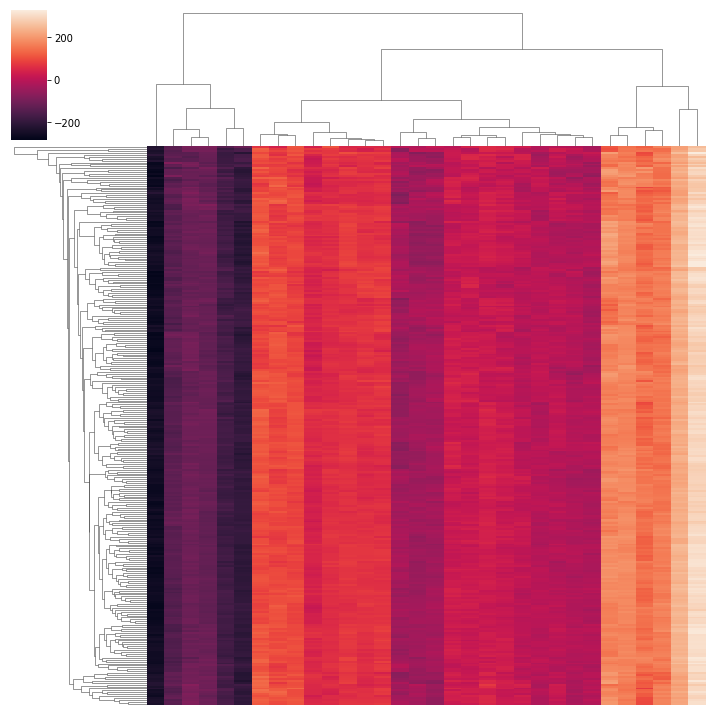

In [65]:
cluster_plot = sns.clustermap(compressed_dataframe,yticklabels=False,xticklabels=False)
cluster_plot
# what do we seeee
# saturation regime everywhere


In [66]:
# let's reconstruct the dataset 
decoded = autoencoder.decoder.predict(compressed_dataframe)
# and flatten it
decoded = decoded.reshape(decoded.shape[0]*decoded.shape[1], -1)


10/10 [==============================] - 0s 4ms/step


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



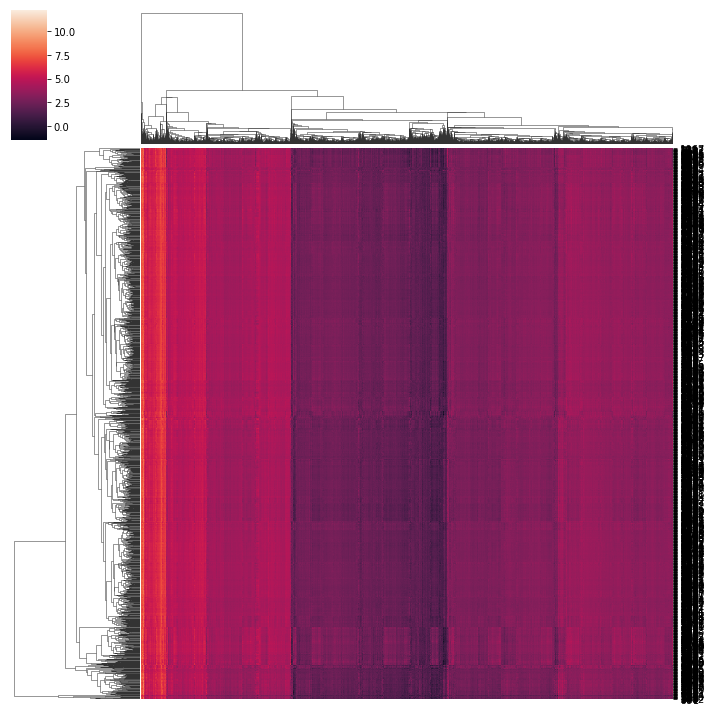

In [67]:
cluster_plot = sns.clustermap(decoded,yticklabels=True,xticklabels=False)
cluster_plot